# Notebook #5: Series temporales: predicción a futuro de la población

In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_funciones_BBDD as sfbd
from src import soporte_sarima as ss
from src import soporte_temporales as st
from src import soporte_variables_poblacion as svp

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

In [2]:
df_poblacion = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svp.query_poblacion)

In [3]:
df_poblacion.head()

,anio,poblacion
0,1960,3298021
1,1961,3408415
2,1962,3521164
3,1963,3635798
4,1964,3752313


In [4]:
df_poblacion.tail()

,anio,poblacion
59,2019,10881882
60,2020,10999664
61,2021,11117873
62,2022,11228821
63,2023,11332972


In [5]:
df_poblacion.columns = ['FECHA', 'Población']
df_poblacion['FECHA'] = pd.to_datetime(df_poblacion['FECHA'].astype(str) + '-12-31')

In [6]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_poblacion, temporal_column="FECHA", value_column="Población")

analisis_st.exploracion_datos()

El número de filas es 64 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Población,64,7329602,2443551,3298021,5203102,7352871,9432392,11332972


In [7]:
analisis_st.comprobar_serie_continua('A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [8]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. Sin embargo, entre el 1990-2000 esta línea que muestra un ascenso casi lineal empieza a mostrar un cambio en su fuerza de aumento. Lo cuál queda más claro a partir del 2010.

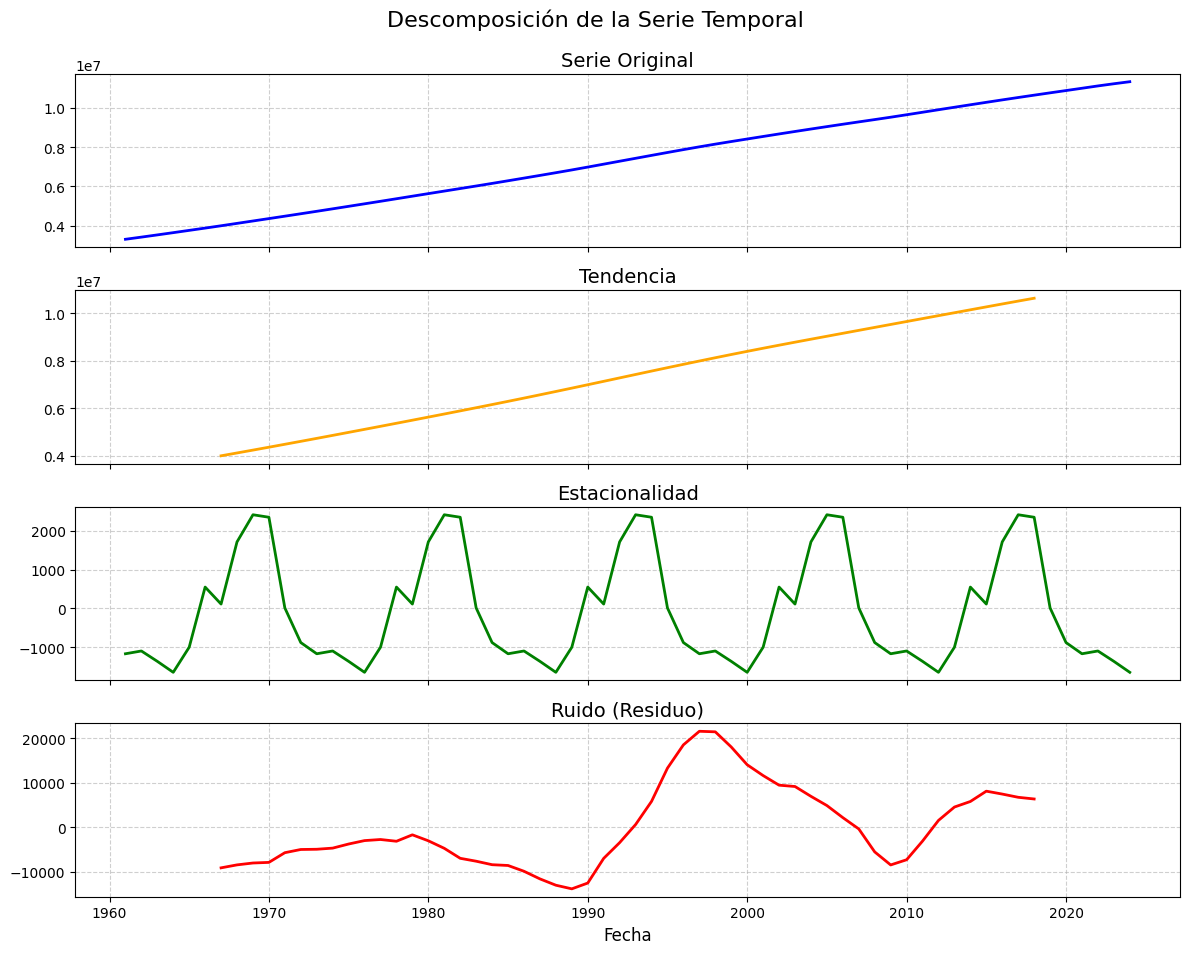

In [9]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

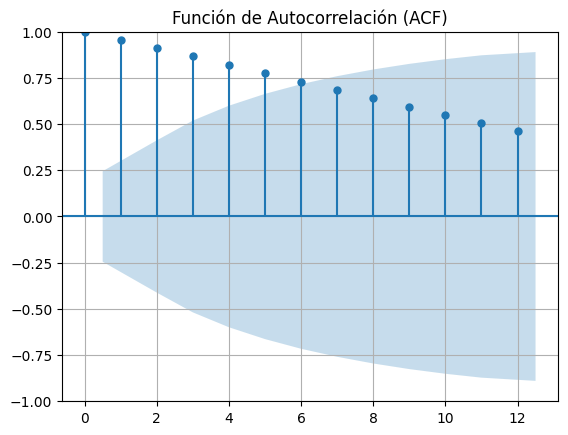

<Figure size 1200x1000 with 0 Axes>

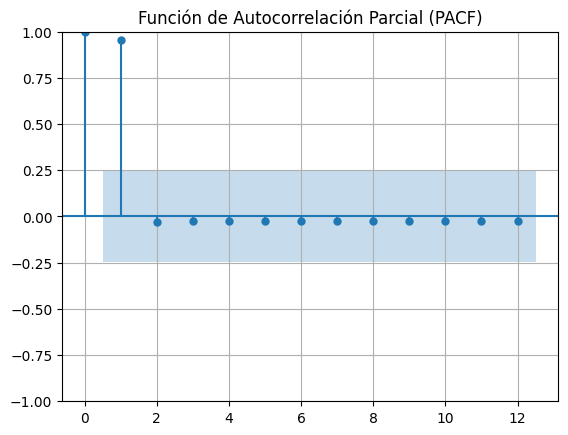

In [10]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Hasta el lag número 6 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del sexto lag, las correlaciones se adentran al intervalo de confianza.

3. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa, indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [11]:
analisis_st.prueba_estacionariedad()

ADF Statistic: -2.019568708932497
p-value: 0.27805935885765015
Valores Críticos:
1%: -3.552928203580539
5%: -2.9147306250000002
10%: -2.595137155612245
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [12]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [13]:
train_size= int(0.7 * len(df_poblacion))
df_poblacion.set_index('FECHA', inplace=True)
df_poblacion.index = pd.to_datetime(df_poblacion.index)
df_poblacion = df_poblacion.asfreq('A')

y_train, y_test = df_poblacion[:train_size], df_poblacion[train_size:]

In [14]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)
resultados_arima.head(3)

  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  4%|▍         | 1/25 [00:00<00:05,  4.58it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

  8%|▊         | 2/25 [00:00<00:05,  3.94it/s]C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 12%|█▏        | 3/25 [00:00<00:08,  2.73it/s]C:\Users\DELL\AppData\Local\Packages\Pyth

,p,q,RMSE
0,1,1,95902
1,1,2,99603
2,1,3,4155560


In [15]:
resultados_arima.head().sort_values(by='RMSE', ascending=True)

,p,q,RMSE
0,1,1,95902
1,1,2,99603
3,1,4,111270
2,1,3,4155560
4,1,5,4677397


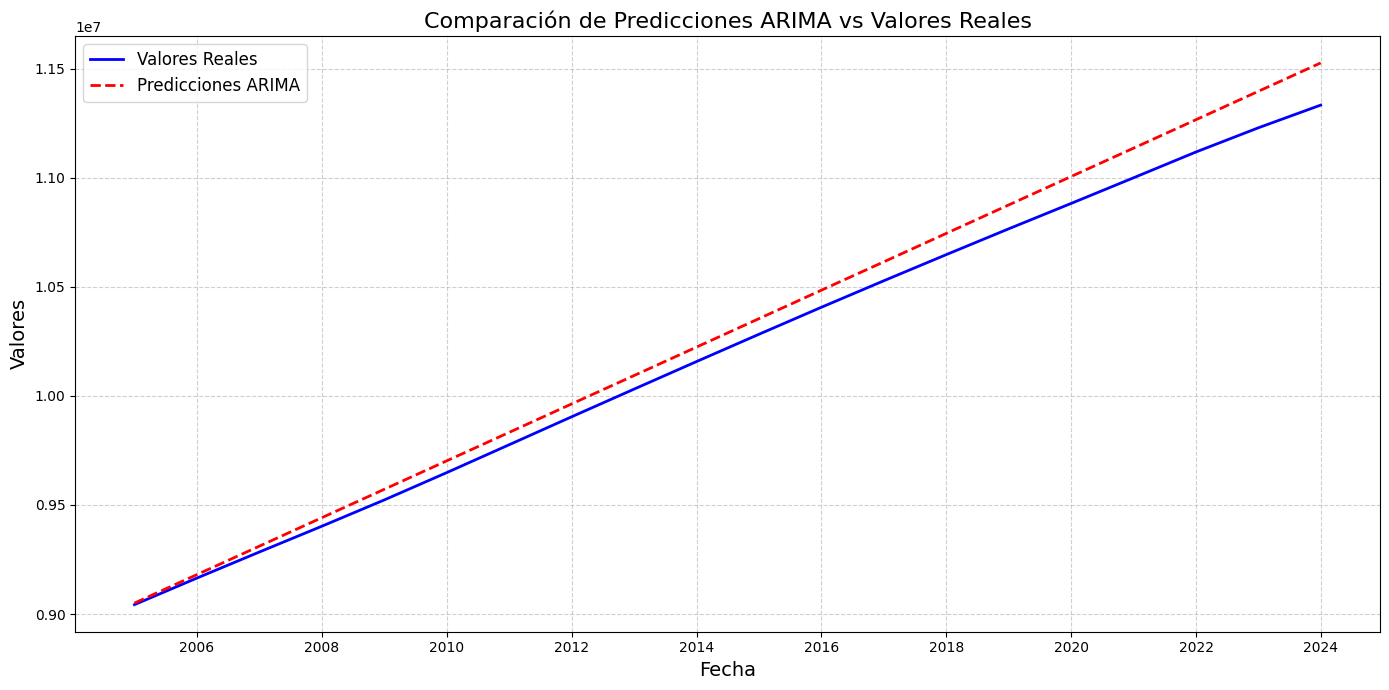

In [16]:
modelo_arima.visualizar_predicciones(y_test)

In [17]:
modelo_arima.best_model['pred_test']

FECHA
2004-12-31    9050236
2005-12-31    9180614
2006-12-31    9310986
2007-12-31    9441351
2008-12-31    9571710
2009-12-31    9702062
2010-12-31    9832408
2011-12-31    9962747
2012-12-31   10093080
2013-12-31   10223407
2014-12-31   10353727
2015-12-31   10484041
2016-12-31   10614348
2017-12-31   10744649
2018-12-31   10874944
2019-12-31   11005232
2020-12-31   11135514
2021-12-31   11265789
2022-12-31   11396058
2023-12-31   11526321
Freq: A-DEC, Name: predicted_mean, dtype: float64

In [18]:
modelo_arima.best_params

{'p': 1, 'q': 1}

### Métricas para el y_test

In [19]:
# Calcular métricas
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 82349.78598646811
MAPE: 0.78%
RMSE: 95901.7042869374


## Métricas para el conjunto completo

In [39]:
# Entrenar el modelo ARIMA con los mejores parámetros en toda la serie histórica
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(2, 1, 6)  # Incluir el parámetro `d=1` o el que hayas usado
).fit()

mejor_modelo_arima.summary()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(2, 1, 6)   Log Likelihood               -2217.673
Date:                Wed, 22 Jan 2025   AIC                           4453.345
Time:                        15:24:27   BIC                           4472.633
Sample:                    12-31-1960   HQIC                          4460.931
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2731      0.048      5.708      0.000       0.179       0.367
ar.L2          0.7266      0.048     15.185      0.000       0.633       0.820
ma.L1         -0.2758      0.048     -5.767      0.000      -0.369      -0.182
ma.L2         -0.7284      0.048    -15.182      0.000      -0.822      -0.634
ma.L3          0.0007      0.001      0.941      0.347      -0.001       0.002
ma.L4          0.0017      0.001      2.716      0.007       0.000       0.003
ma.L5          0.0050      0.001      9.550      0.000       0.004       0.006
ma.L6          0.0051      0.000     12.522      0.000       0.004       0.006
sigma2      1.731e+06   4.89e-07   3.54e+12      0.000    1.73e+06    1.73e+06
===================================================================================
Ljung-Box (L1) (Q):                  55.05   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.00   Prob(JB):                         0.34
Heteroskedasticity (H):               5.04   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.54e+26. Standard errors may be unstable.
"""

In [43]:
pred_todo = mejor_modelo_arima.predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Población"],
    "Predicción": pred_todo
})
pred_df

,Fecha,Valor Real,Predicción
FECHA,,,
1960-12-31,1960-12-31,3298021,0
1961-12-31,1961-12-31,3408415,3412820
1962-12-31,1962-12-31,3521164,3523053
1963-12-31,1963-12-31,3635798,3636995
1964-12-31,1964-12-31,3752313,3754044
...,...,...,...
2019-12-31,2019-12-31,10881882,10894564
2020-12-31,2020-12-31,10999664,11010765
2021-12-31,2021-12-31,11117873,11128397


In [44]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 59117.887326149976
MAPE para toda la serie: 1.67%
RMSE para toda la serie: 412366.434868235


## Métricas sin el primer año

In [45]:
# Calcular métricas
mae_todo = mean_absolute_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:]))

# Mostrar resultados
print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 7706.726807517435
MAPE para toda la serie: 0.11%
RMSE para toda la serie: 9764.193038815703


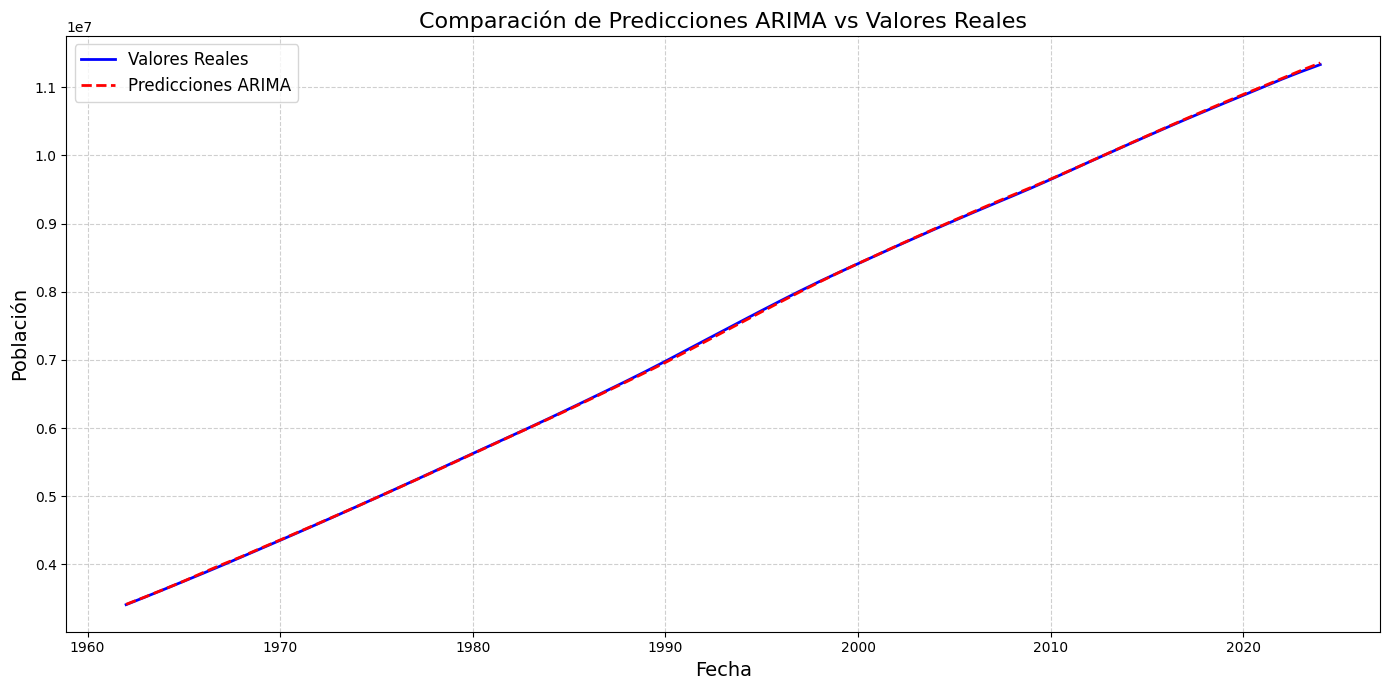

In [51]:
# Configuración de la figura
plt.figure(figsize=(14, 7))

# Graficar valores reales
sns.lineplot(data=pred_df[1:], x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2)

# Graficar predicciones
sns.lineplot(data=pred_df[1:], x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2)

# Personalización de la gráfica
plt.title("Comparación de Predicciones ARIMA vs Valores Reales", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Población", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

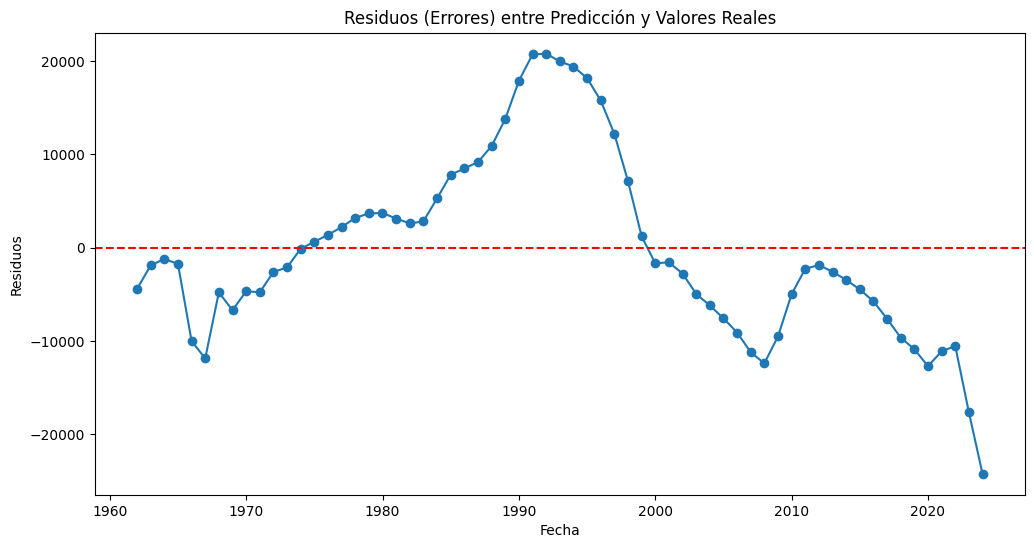

In [52]:
residuos = pred_df["Valor Real"] - pred_df["Predicción"]
plt.figure(figsize=(12, 6))
plt.plot(pred_df["Fecha"][1:], residuos[1:], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos (Errores) entre Predicción y Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.show()

## Aplicar mejores parámetros y predecir

In [53]:
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(2, 1, 6)  
).fit()

print(mejor_modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              Población   No. Observations:                   64
Model:                 ARIMA(2, 1, 6)   Log Likelihood               -2217.673
Date:                Wed, 22 Jan 2025   AIC                           4453.345
Time:                        15:30:30   BIC                           4472.633
Sample:                    12-31-1960   HQIC                          4460.931
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2731      0.048      5.708      0.000       0.179       0.367
ar.L2          0.7266      0.048     15.185      0.000       0.633       0.820
ma.L1         -0.2758      0.048     -5.767      0.0

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Utilicé el parámetro, d=2, porque al utilizar 1 como valor todas las predicciones eran iguales.

In [54]:
# Predecir los próximos 2 años (por ejemplo)
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2024-12-31   11461092
2025-12-31   11589103
2026-12-31   11717001
Freq: A-DEC, Name: predicted_mean, dtype: float64


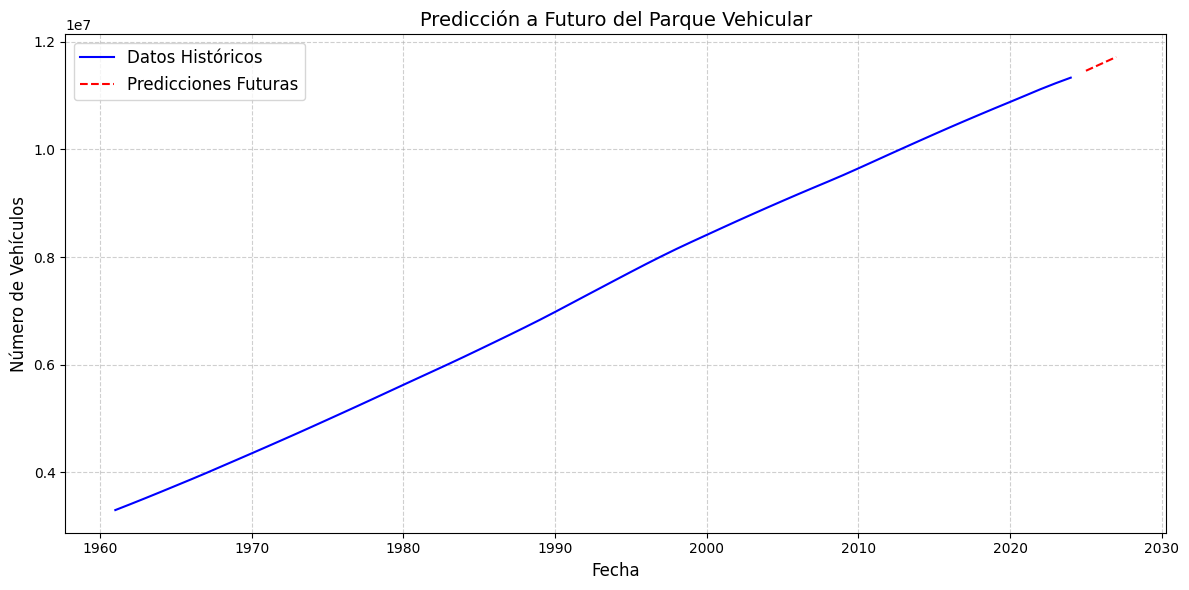

In [55]:
# Crear un rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# Crear un DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

# Unir las predicciones futuras con los datos históricos
datos_historicos_df = pd.concat([y_train, y_test])
datos_historicos_df = pd.DataFrame(datos_historicos_df).reset_index()
datos_historicos_df.columns = ['Fecha', 'Valor Real']

# Graficar los datos
plt.figure(figsize=(12, 6))

# Graficar datos históricos
plt.plot(datos_historicos_df['Fecha'], datos_historicos_df['Valor Real'], label='Datos Históricos', color='blue')

# Graficar predicciones futuras
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar el gráfico
plt.show()